# Planet Classifier:

In [ ]:
!pip install -Uqq fastai
!pip install -Uqq duckduckgo_search

In [ ]:
from time import sleep
from fastcore.all import *
from fastai.vision.all import *
from duckduckgo_search import ddg_images

def search_images(term: str, max_images: int = 200) -> list:
    """ Return list of downloadable images urls """
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

### Step 1: Load Planets pictures:

In [ ]:
planets_list = ['Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune', 'random']
path_to_planets = Path('planets')

for planet in planets_list:
    dest = (path_to_planets/planet)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{planet} photo', 1500))
    resize_images(dest, max_size=400, dest=dest)

failed = verify_images(get_image_files(path_to_planets))
failed.map(Path.unlink)
len(failed)

### Step 2: Prepare Dataloader:

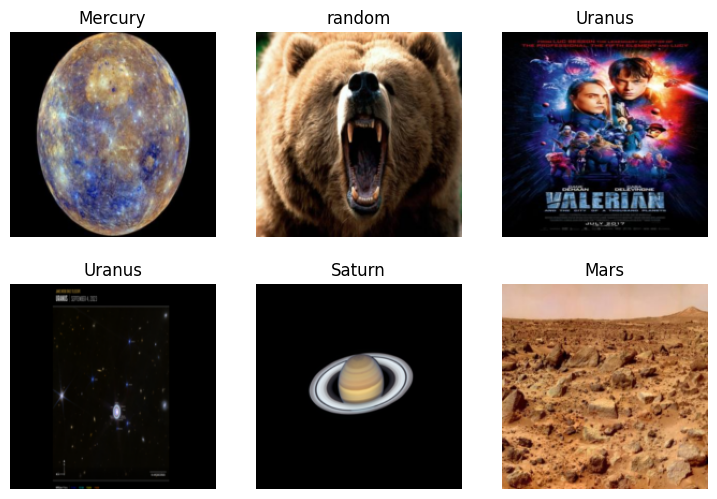

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path_to_planets)

dls.show_batch(max_n=6)

### Step 3: Train our model

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(15)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s]


In [ ]:
learn.export('planet_cls_1.pkl')

### Step 4: Prediction

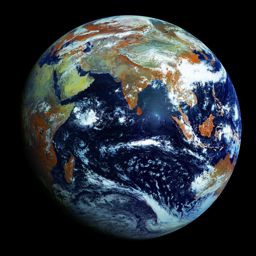

In [ ]:
from fastdownload import download_url

urls = search_images('earth photo', max_images=1)
test_dest = 'test.jpg'
download_url(urls[0], test_dest, show_progress=False)
im = Image.open(test_dest)
im.to_thumb(256, 256)

In [ ]:
pred_label, index_label, probs_label = learn.predict(PILImage.create(test_dest))
print(f"This is a: {pred_label}.")
print(f"Probability is a : {probs_label[0]:.4f}")

This is a: Earth.
Probability is a : 0.9997


# Test app:

In [ ]:
!pip install -Uqq fastai
!pip install -Uq gradio

In [2]:
import gradio as gr
from fastai.vision.all import *

learn = load_learner('planet_cls_1.pkl')
labels = learn.dls.vocab

def planet_classifier_predict(img) -> str:
  img = PILImage.create(img)
  pred, pred_idx, probs = learn.predict(img)
  return {labels[i]: float(probs[i]) for i in range(len(labels))}

In [ ]:
title = "Planet Classifier Demo"
description = "Let's say you want to classify a picture if it is one of the 9 planets: \
                Mercury, Venus, Earth, Mars, Jupiter, Saturn, Uranus, and Neptune. \
                You can do it using this awesome tool!!!! Try it :)"
article = "<p style='text-align: center'><a href='https://www.tanishq.ai/blog/posts/2021-11-16-gradio-huggingface.html' target='_blank'>This project is based on this source.</a></p>"
examples = ['./example_images/saturn.jpeg', './example_images/car.jpeg']
interpretation = 'default'
enable_queue = True
inputs = "image"
outputs = "label"

gr.Interface(
    fn=planet_classifier_predict,
    inputs=inputs,
    outputs=outputs,
    title=title,
    description=description,
    article=article,
    examples=examples,
).launch()